# Erdos Institute Fall 2025  
## Exploratory Data Analysis: Possible features to include in final analysis for Patient Readmission Risk Project


Data is from ~ 22,000 synthetic patients generated by Shivani Chowdhry using the Synthea data generator, which creates synthetic electronic health records. Modelling aim is to use EHR features to predict hospital readmission rate after an inpatient encounter. 

The "patients" file includes the base patient data.
The "encounters" file includes all hospital encounters for those patients. 

The additional file analyzed here is "medications.csv" 

The purpose of this EDA is to identify whether the "medications" data contains any features that warrant possible inclusion in a predictive model.

In [2]:

# Basic setup
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve
)
from sklearn.calibration import CalibrationDisplay

# Set the base path to CSV files
path = "C:/Users/edenm/OneDrive/Desktop/Training/Online_coursework/Erdos/Erdos_2025_project/"

# Load csv tables for patient data
patients = pd.read_csv(path + "patients.csv")
encounters = pd.read_csv(path + "encounters.csv")
medications = pd.read_csv(path + "medications.csv")

# Print file information
print("Patients:", patients.shape)
print("Encounters:", encounters.shape)
print("Medications:", medications.shape)



Patients: (22025, 28)
Encounters: (1320125, 15)
Medications: (1133505, 13)


Shivani wrote the following code to create a "readmission" metric for the encounters data. I have copied it here (Google Collab, version 10/26/2025)

In [3]:
# Number of unique patients
patients['Id'].nunique()

# Number of encounters per patient (first 5)
enc_per_patient = encounters.groupby('PATIENT').size().head()
print(enc_per_patient)

# Check a few columns
print(patients.columns)
print(encounters.columns)
print(medications.columns)

PATIENT
00010e8f-590e-3608-5307-0c075d7b83b6     27
00037657-224c-8a27-8e00-252779d41cc3     36
0004e2d2-969c-2b8e-b5c3-b1cc51eac06a     72
00070edc-4a3d-6dcb-de91-39d828ea23c5    544
00097b68-2bce-3e49-4b50-c28f44deed0b    302
dtype: int64
Index(['Id', 'BIRTHDATE', 'DEATHDATE', 'SSN', 'DRIVERS', 'PASSPORT', 'PREFIX',
       'FIRST', 'MIDDLE', 'LAST', 'SUFFIX', 'MAIDEN', 'MARITAL', 'RACE',
       'ETHNICITY', 'GENDER', 'BIRTHPLACE', 'ADDRESS', 'CITY', 'STATE',
       'COUNTY', 'FIPS', 'ZIP', 'LAT', 'LON', 'HEALTHCARE_EXPENSES',
       'HEALTHCARE_COVERAGE', 'INCOME'],
      dtype='object')
Index(['Id', 'START', 'STOP', 'PATIENT', 'ORGANIZATION', 'PROVIDER', 'PAYER',
       'ENCOUNTERCLASS', 'CODE', 'DESCRIPTION', 'BASE_ENCOUNTER_COST',
       'TOTAL_CLAIM_COST', 'PAYER_COVERAGE', 'REASONCODE',
       'REASONDESCRIPTION'],
      dtype='object')
Index(['START', 'STOP', 'PATIENT', 'PAYER', 'ENCOUNTER', 'CODE', 'DESCRIPTION',
       'BASE_COST', 'PAYER_COVERAGE', 'DISPENSES', 'TOTALCOST', 

In [4]:
# Filter for inpatient encounters (hospital admissions/discharges):
inpatient = encounters[encounters['ENCOUNTERCLASS'] == 'inpatient'].copy()


In [5]:
# Convert START and STOP times to datetime:
inpatient['START'] = pd.to_datetime(inpatient['START'])
inpatient['STOP']  = pd.to_datetime(inpatient['STOP'])

In [6]:
# Create the “readmission within 30 days” label
inpatient = inpatient.sort_values(['PATIENT', 'START'])
inpatient['NEXT_START'] = inpatient.groupby('PATIENT')['START'].shift(-1)
inpatient['READMIT_30D'] = (
    (inpatient['NEXT_START'] - inpatient['STOP']).dt.days <= 30
) & (
    (inpatient['NEXT_START'] - inpatient['STOP']).dt.days > 0
)
inpatient['READMIT_30D'] = inpatient['READMIT_30D'].fillna(False).astype(int)

In [7]:
# Engineering features
# Age
patients['BIRTHDATE'] = pd.to_datetime(patients['BIRTHDATE'])
patients['AGE'] = (pd.Timestamp('today') - patients['BIRTHDATE']).dt.days / 365

# Merge patient info into encounters
data = inpatient.merge(patients[['Id','AGE','GENDER','RACE','ETHNICITY']],
                       left_on='PATIENT', right_on='Id', how='left')

# Example feature set
X = data[['AGE', 'GENDER', 'RACE', 'ETHNICITY']].copy()
y = data['READMIT_30D']

# Convert categorical features to dummies
X = pd.get_dummies(X, drop_first=True)

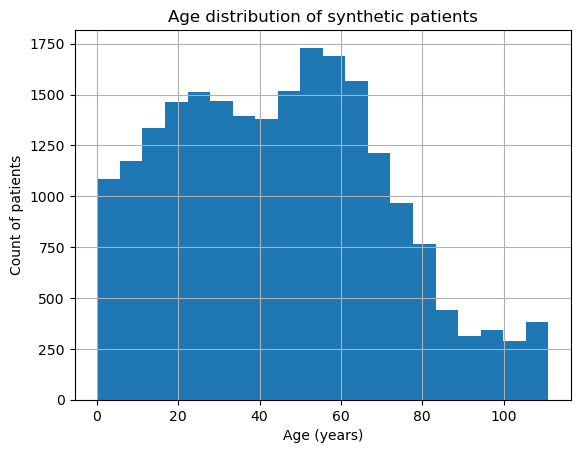

In [8]:
# Data plotting

# Convert birthdate to age in years
patients['BIRTHDATE'] = pd.to_datetime(patients['BIRTHDATE'])
patients['AGE'] = (pd.Timestamp('today') - patients['BIRTHDATE']).dt.days / 365

patients['AGE'].hist(bins=20)
plt.xlabel("Age (years)")
plt.ylabel("Count of patients")
plt.title("Age distribution of synthetic patients")
plt.show()

Next, Exploring the "Medications" data.

In [9]:
# Medications data exploration:

# How many rows and columns?
print("Medications:", medications.shape)

# What are the columns?
print(medications.columns)

# Cast the "CODE" column as a string:
medications['CODE'] = medications['CODE'].astype(str)

# How many patients took medication at any time, and how many total unique medications are in the dataset?
print("Unique medications:", medications['CODE'].nunique())

Medications: (1133505, 13)
Index(['START', 'STOP', 'PATIENT', 'PAYER', 'ENCOUNTER', 'CODE', 'DESCRIPTION',
       'BASE_COST', 'PAYER_COVERAGE', 'DISPENSES', 'TOTALCOST', 'REASONCODE',
       'REASONDESCRIPTION'],
      dtype='object')
Unique medications: 383


In [10]:
print("Unique medications:", medications['DESCRIPTION'].nunique())

Unique medications: 399


>There are more descriptions than there are codes for medications. 

In [11]:
# Find out which Codes are matching to more than one Description:
duplicates = (
    medications.groupby('CODE')['DESCRIPTION']
    .nunique()            # count unique Descriptions per Code
    .reset_index(name="unique_descriptions")
)

# Filter for Code values that map to more than one Description
violations = duplicates[duplicates["unique_descriptions"] > 1]

print(violations)


        CODE  unique_descriptions
0    1000126                    2
4    1049221                    2
34   1437975                    2
53   1659149                    2
80   1804799                    2
162   242969                    2
163   243670                    2
165   245314                    2
182   309362                    2
201   312961                    2
215   314231                    2
242   583214                    2
296   855332                    2
307   856987                    2
373   979485                    2
382   999999                    3


In [12]:
# Which Descriptions are used more than once?
problem_mappings = (
    medications.groupby("CODE")["DESCRIPTION"]
    .agg(lambda x: list(set(x)))
    .reset_index()
)

problem_mappings = problem_mappings[problem_mappings["DESCRIPTION"].apply(len) > 1]
print(problem_mappings)

        CODE                                        DESCRIPTION
0    1000126  [1 ML medroxyPROGESTERone acetate 150 MG/ML In...
4    1049221  [Acetaminophen 325 MG / oxyCODONE Hydrochlorid...
34   1437975  [Glycopyrrolate 1.5 MG Oral Tablet [Glycate], ...
53   1659149  [piperacillin 4000 MG / tazobactam 500 MG Inje...
80   1804799  [Alteplase 100 MG Injection, alteplase 100 MG ...
162   242969  [4 ML norepinephrine 1 MG/ML Injection, 4 ML N...
163   243670  [Aspirin 81 MG Oral Tablet, aspirin 81 MG Oral...
165   245314  [albuterol 5 MG/ML Inhalation Solution, Albute...
182   309362  [clopidogrel 75 MG Oral Tablet, Clopidogrel 75...
201   312961  [Simvastatin 20 MG Oral Tablet, simvastatin 20...
215   314231  [Simvastatin 10 MG Oral Tablet, simvastatin 10...
242   583214  [PACLitaxel 100 MG Injection, Paclitaxel 100 M...
296   855332  [Warfarin Sodium 5 MG Oral Tablet, warfarin so...
307   856987  [Acetaminophen 300 MG / Hydrocodone Bitartrate...
373   979485  [Losartan Potassium 25 MG 

Most of these duplicates are minor variation like a capitalization discrepency, so we can safely just use the "CODE" column in this case as well.

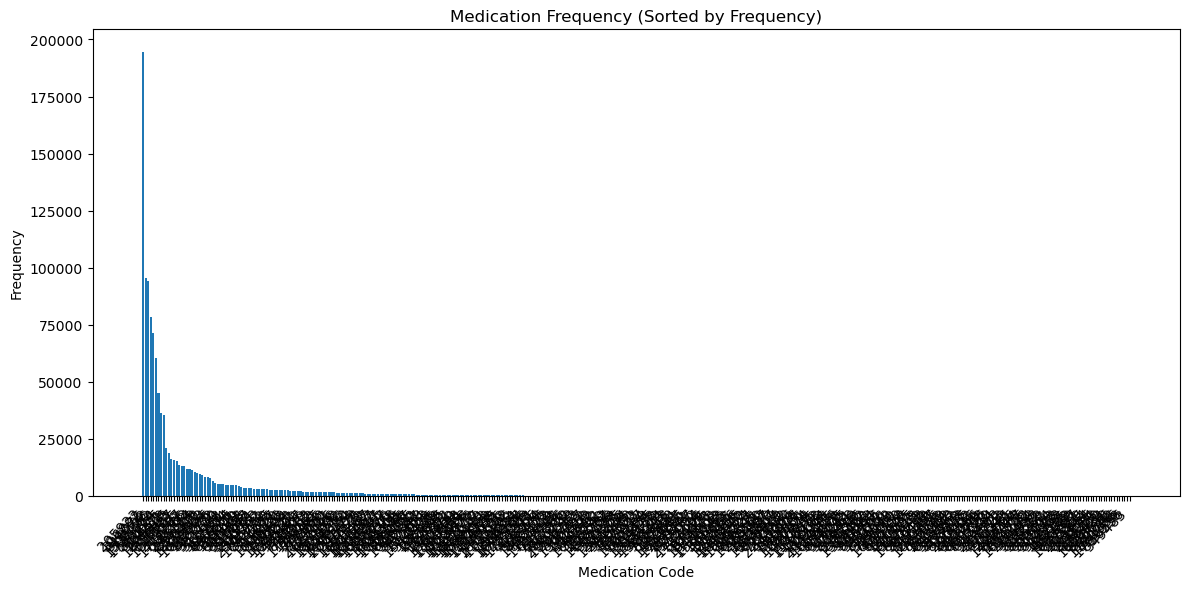

In [13]:
frequency_counts = medications['CODE'].value_counts()

# Create a bar plot using the sorted frequencies
plt.figure(figsize=(12, 6))
plt.bar(frequency_counts.index, frequency_counts.values)
plt.xlabel('Medication Code')
plt.ylabel('Frequency')
plt.title('Medication Frequency (Sorted by Frequency)')
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability if needed
plt.tight_layout()
plt.show()



As with the Immunizations, some medications are very common, whereas others are less so. Let's look at a few frequency bins to see which medications we might want to include:

In [14]:
counts = medications["CODE"].value_counts().reset_index()
counts.columns = ["medication", "row_count"]

# Define bins and labels
bins = [0, 100, 1000, 10000, 50000, float("inf")]
labels = ["0–100", "101–1000", "1001–10000", "10001–50000", ">50000"]

# Assign each unique medication to a bin based on its row count
counts["bin"] = pd.cut(counts["row_count"], bins=bins, labels=labels, right=True)

# Step 4. Count how many unique values fall into each bin
summary = counts["bin"].value_counts().sort_index().reset_index()
summary.columns = ["row_count_range", "num_unique_values"]

print(summary)

  row_count_range  num_unique_values
0           0–100                206
1        101–1000                 90
2      1001–10000                 66
3     10001–50000                 15
4          >50000                  6


Of the total 399, 206 medications were prescribed 100 times or less. These should definitely be excluded. The 90 in the 101-1000 range can also be dropped. That leaves 87 medications that were prescribed 1000 times or more. Here, the data are filtered to include only medications in the top two bins. More can be added back in later. 

(883481, 13)


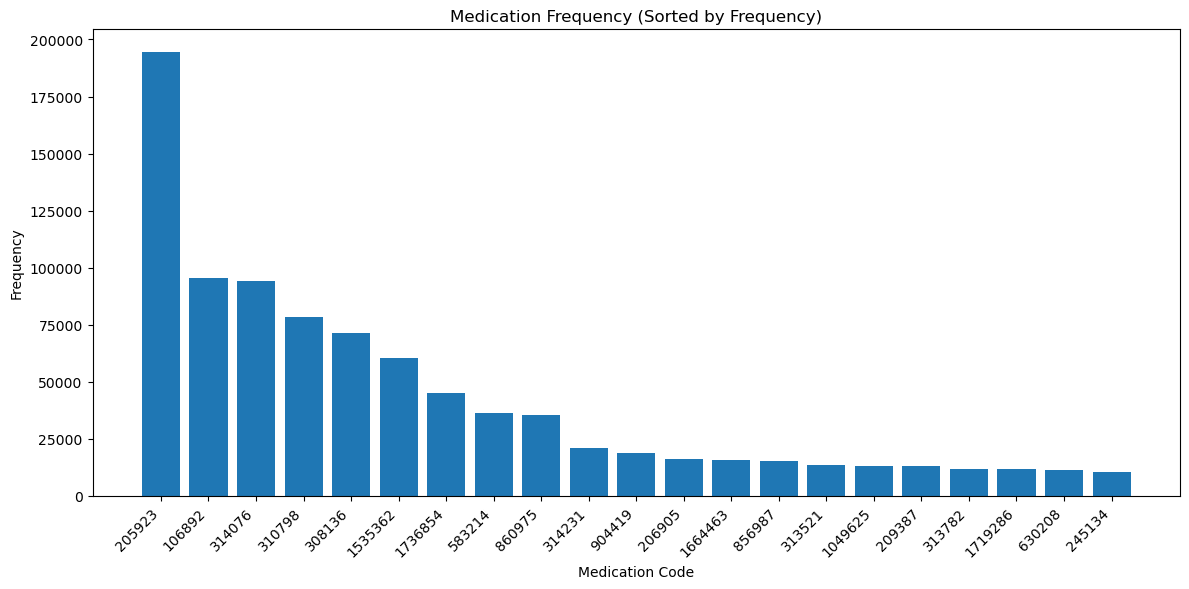

In [15]:
# Identify the bins to keep (top 3)
bins_to_keep = ["10001–50000", ">50000"]

# Get the unique medication code values in those bins
values_to_keep = counts.loc[counts["bin"].isin(bins_to_keep), "medication"]

# Step 3: filter your original DataFrame
medications_filtered = medications[medications["CODE"].isin(values_to_keep)]

print(medications_filtered.shape)


frequency_counts = medications_filtered['CODE'].value_counts()

# Create a bar plot using the sorted frequencies
plt.figure(figsize=(12, 6))
plt.bar(frequency_counts.index, frequency_counts.values)
plt.xlabel('Medication Code')
plt.ylabel('Frequency')
plt.title('Medication Frequency (Sorted by Frequency)')
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability if needed
plt.tight_layout()
plt.show()

In [16]:
summary_table = (
    medications_filtered.groupby("CODE")
    .agg(
        row_count=("DESCRIPTION", "size"),
        associated_C_values=("DESCRIPTION", lambda x: ", ".join(sorted(set(x))))
    )
    .reset_index()
    .sort_values("row_count", ascending=False)  # rank by frequency
)

print(summary_table)

       CODE  row_count                                associated_C_values
6    205923     194713   1 ML Epoetin Alfa 4000 UNT/ML Injection [Epogen]
1    106892      95323  insulin isophane  human 70 UNT/ML / insulin  r...
14   314076      94178                       lisinopril 10 MG Oral Tablet
11   310798      78217              Hydrochlorothiazide 25 MG Oral Tablet
10   308136      71570                      amLODIPine 2.5 MG Oral Tablet
2   1535362      60570              sodium fluoride 0.0272 MG/MG Oral Gel
5   1736854      45053                          Cisplatin 50 MG Injection
16   583214      36233  PACLitaxel 100 MG Injection, Paclitaxel 100 MG...
19   860975      35511  24 HR Metformin hydrochloride 500 MG Extended ...
15   314231      20823  Simvastatin 10 MG Oral Tablet, simvastatin 10 ...
20   904419      18813                  Alendronic acid 10 MG Oral Tablet
7    206905      16294                 Ibuprofen 400 MG Oral Tablet [Ibu]
3   1664463      15679  24 HR tacrolim

If we want to use these as features, they will have to be one hot encoded and then added to a column after being matched to encounters via overlap with encounter date. 
However, as per our meeting discussion, the feature to engineer first is simply the number of medications that a patient was on at the time of each encounter:

In [17]:
# --- Load subset of data ---
encounters_subset = pd.read_csv(
    "encounters.csv",
    usecols=['Id','START', 'STOP', 'PATIENT'],   
    parse_dates=["START", "STOP"]
)

medications_subset = pd.read_csv(
    "medications.csv",
    usecols=['START', 'STOP', 'PATIENT', 'ENCOUNTER'],   
    parse_dates=['START', 'STOP']
)

# Rename columns for clarity
encounters_subset.columns = ['ENCOUNTER', 'START_ENC', 'STOP_ENC', 'PATIENT']
medications_subset.columns = ['START_MED', 'STOP_MED', 'PATIENT', 'ENCOUNTER']

# --- Convert all date columns to datetime explicitly ---
for col in ['START_ENC', 'STOP_ENC']:
    encounters_subset[col] = pd.to_datetime(encounters_subset[col], errors="coerce", utc=True)

for col in ['START_MED', 'STOP_MED']:
    medications_subset[col] = pd.to_datetime(medications_subset[col], errors="coerce", utc=True)

# --- Merge encounters with medications on UUID ---
merged = encounters_subset.merge(medications_subset, on='PATIENT', how="left")

# --- Check if the encounter start is within a medication period ---
mask = (merged['START_ENC'] >= merged['START_MED']) & (merged['START_ENC'] <= merged['STOP_MED'])
merged["active_medication"] = mask

# --- Count how many active conditions each encounter start has ---
medication_counts = (
    merged[merged["active_medication"]]
    .groupby(['START_ENC', 'STOP_ENC', 'PATIENT'])
    .size()
    .reset_index(name="num_medications_at_start")
)

# --- Merge back to encounters (fill 0 where no medication matched) ---
encounters_subset = encounters_subset.merge(
    medication_counts,
    on=['START_ENC', 'STOP_ENC', 'PATIENT'],
    how="left"
).fillna({"num_medications_at_start": 0})

# --- Convert to integer ---
encounters_subset["num_medications_at_start"] = encounters_subset["num_medications_at_start"].astype(int)

# --- Save output ---
#encounters_subset.to_csv("encounters_with_medications_counts.csv", index=False)

print(encounters_subset.head())


                              ENCOUNTER                 START_ENC  \
0  f173c55d-26fa-40a7-b077-8cc08109602a 2024-08-12 19:52:00+00:00   
1  f173c55d-26fa-40a7-5739-e1010ba4aa6f 2024-09-16 19:52:00+00:00   
2  f173c55d-26fa-40a7-a618-1b0f619c9469 2024-11-18 19:52:00+00:00   
3  f173c55d-26fa-40a7-ca3a-a615921a881a 2025-01-20 19:52:00+00:00   
4  f173c55d-26fa-40a7-be65-14cedc9bf4a4 2025-04-21 19:52:00+00:00   

                   STOP_ENC                               PATIENT  \
0 2024-08-12 20:07:00+00:00  f173c55d-26fa-40a7-4d3d-a0a77af219ec   
1 2024-09-16 20:07:00+00:00  f173c55d-26fa-40a7-4d3d-a0a77af219ec   
2 2024-11-18 20:07:00+00:00  f173c55d-26fa-40a7-4d3d-a0a77af219ec   
3 2025-01-20 20:07:00+00:00  f173c55d-26fa-40a7-4d3d-a0a77af219ec   
4 2025-04-21 20:07:00+00:00  f173c55d-26fa-40a7-4d3d-a0a77af219ec   

   num_medications_at_start  
0                         0  
1                         0  
2                         0  
3                         0  
4                   

In [18]:
encounters_subset['num_medications_at_start'].max()

np.int64(39)

Make a histogram to see what the distribution is like:

<Axes: >

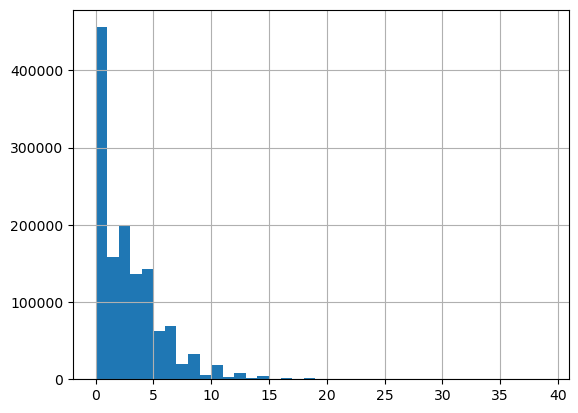

In [19]:
encounters_subset['num_medications_at_start'].hist(bins=39)

The number with the greatest frequency is 0 medications, but there are still plenty in the others up to about 10. Few encounters saw people taking more than 10, although 10 is more common than 9, which is a bit odd!  

Can also bin them to get totals in some of the categories: 

In [34]:

# Define the bins and labels for your ranges
bins = [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, float("inf")]
labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", ">10"]

# Bin the values in num_conditions_at_start
encounters_subset["medication_range"] = pd.cut(
    encounters_subset["num_medications_at_start"],
    bins=bins,
    labels=labels,
    right=True
)

# Count how many rows fall into each range
summary = encounters_subset["medication_range"].value_counts().reindex(labels, fill_value=0)

# Convert to a DataFrame for a clean table
summary_table = summary.reset_index()
summary_table.columns = ["num_medication_range", "count"]

print(summary_table)
print("Medications:", encounters_subset.shape)

   num_medication_range   count
0                     0  455715
1                     1  157803
2                     2  198209
3                     3  136761
4                     4  142871
5                     5   62461
6                     6   68451
7                     7   19998
8                     8   33103
9                     9    5838
10                   10   18505
11                  >10   20410
Medications: (1320125, 5)


In [20]:

print(data.columns)
print(encounters_subset.columns)

Index(['Id_x', 'START', 'STOP', 'PATIENT', 'ORGANIZATION', 'PROVIDER', 'PAYER',
       'ENCOUNTERCLASS', 'CODE', 'DESCRIPTION', 'BASE_ENCOUNTER_COST',
       'TOTAL_CLAIM_COST', 'PAYER_COVERAGE', 'REASONCODE', 'REASONDESCRIPTION',
       'NEXT_START', 'READMIT_30D', 'Id_y', 'AGE', 'GENDER', 'RACE',
       'ETHNICITY'],
      dtype='object')
Index(['ENCOUNTER', 'START_ENC', 'STOP_ENC', 'PATIENT',
       'num_medications_at_start'],
      dtype='object')


In [ ]:
# Merge encounters, patients, and number of medications metric

# --- Rename 'data' Id column to match medications 'encounter', and drop the redundant 'Id_y' column, which is identical to 'PATIENT' 
data.rename(columns={'Id_x':'ENCOUNTER'}, inplace=True)
data = data.drop('Id_y', axis=1)

# --- Merge the num_medications_at_start feature column into the inpatient dataset ---
data = data.merge(
    encounters_subset[['ENCOUNTER', 'num_medications_at_start']],
    on='ENCOUNTER',
    how="left"
)


In [27]:
print(data.columns)

Index(['ENCOUNTER', 'START', 'STOP', 'PATIENT', 'ORGANIZATION', 'PROVIDER',
       'PAYER', 'ENCOUNTERCLASS', 'CODE', 'DESCRIPTION', 'BASE_ENCOUNTER_COST',
       'TOTAL_CLAIM_COST', 'PAYER_COVERAGE', 'REASONCODE', 'REASONDESCRIPTION',
       'NEXT_START', 'READMIT_30D', 'AGE', 'GENDER', 'RACE', 'ETHNICITY',
       'num_medications_at_start'],
      dtype='object')


In [28]:
summary = pd.crosstab(data["num_medications_at_start"], data["READMIT_30D"])

summary.index.name = "Number of medications patient takes"
summary.columns.name = "Readmitted within 30 days"

print(summary)

Readmitted within 30 days               0     1
Number of medications patient takes            
0                                    8845  1031
1                                    1933   171
2                                    2494  1122
3                                    1588   521
4                                    1170   282
5                                     746   233
6                                     508   199
7                                     384   129
8                                     164   122
9                                      40     4
10                                     27     1
11                                     32    12
12                                     11     6
13                                      5     4
14                                      1     4


In [29]:
# --- Define features and outcome ---
X = data[["num_medications_at_start"]].astype(int)
y = data["READMIT_30D"].astype(int)
groups = data["PATIENT"]  # will be employed for group-aware splitting

# --- Group-aware split to avoid data leakage (so patients will not appear in both sets) ---
gss = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# --- Fit logistic regression ---
model = LogisticRegression(class_weight="balanced", solver="liblinear", random_state=42)
model.fit(X_train, y_train)

# --- Predict and get probabilities ---
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# --- Evaluate performance ---
print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("ROC AUC:", round(roc_auc_score(y_test, y_prob), 3))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=3))

# --- View model coefficients ---
coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_[0]
})
print("\nModel coefficients:\n", coef_df)

Accuracy: 0.688
ROC AUC: 0.583

Confusion Matrix:
 [[3844 1379]
 [ 520  340]]

Classification Report:
               precision    recall  f1-score   support

           0      0.881     0.736     0.802      5223
           1      0.198     0.395     0.264       860

    accuracy                          0.688      6083
   macro avg      0.539     0.566     0.533      6083
weighted avg      0.784     0.688     0.726      6083


Model coefficients:
                     Feature  Coefficient
0  num_medications_at_start     0.216784


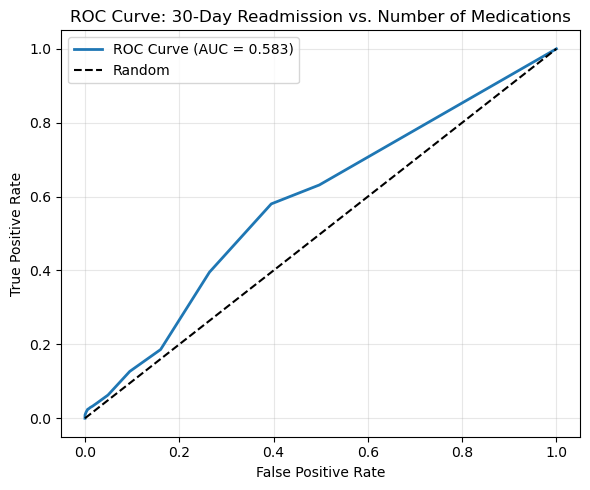

<Figure size 600x500 with 0 Axes>

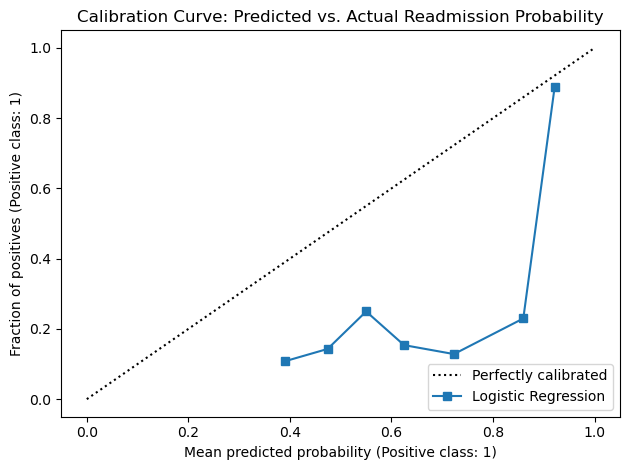

In [30]:
# --- ROC Curve

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})", linewidth=2)
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: 30-Day Readmission vs. Number of Medications")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# --- Calibration Curve

plt.figure(figsize=(6, 5))
CalibrationDisplay.from_estimator(
    model,
    X_test,
    y_test,
    n_bins=10,
    strategy='uniform',
    name="Logistic Regression"
)
plt.title("Calibration Curve: Predicted vs. Actual Readmission Probability")
plt.tight_layout()
plt.show()

Model performs very poorly with this predictor alone. Adding in some basic demographic data as well:

In [ ]:
# choose predictor columns
predictors = [
    # Demographics
    'AGE', 'GENDER', 'RACE', 'ETHNICITY',
    # Medication feature
    'num_medications_at_start'
]


In [41]:
# --- Define features and outcome ---
X = data[predictors]
y = data["READMIT_30D"].astype(int)
groups = data["PATIENT"]  # will be employed for group-aware splitting

# Convert categorical features to dummies
X = pd.get_dummies(X, drop_first=True)

# --- Group-aware split to avoid data leakage (so patients will not appear in both sets) ---
gss = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# --- Fit logistic regression ---
model = LogisticRegression(class_weight="balanced", solver="liblinear", random_state=42)
model.fit(X_train, y_train)

# --- Predict and get probabilities ---
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# --- Evaluate performance ---
print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("ROC AUC:", round(roc_auc_score(y_test, y_prob), 3))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=3))

# --- View model coefficients ---
coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_[0]
})
print("\nModel coefficients:\n", coef_df)

Accuracy: 0.649
ROC AUC: 0.674

Confusion Matrix:
 [[3494 1729]
 [ 409  451]]

Classification Report:
               precision    recall  f1-score   support

           0      0.895     0.669     0.766      5223
           1      0.207     0.524     0.297       860

    accuracy                          0.649      6083
   macro avg      0.551     0.597     0.531      6083
weighted avg      0.798     0.649     0.699      6083


Model coefficients:
                     Feature  Coefficient
0                       AGE     0.030097
1  num_medications_at_start     0.090115
2                  GENDER_M     0.658502
3                RACE_black    -0.316377
4             RACE_hawaiian    -0.369026
5               RACE_native    -1.609280
6                RACE_other    -0.216965
7                RACE_white    -0.194354
8     ETHNICITY_nonhispanic    -0.115687


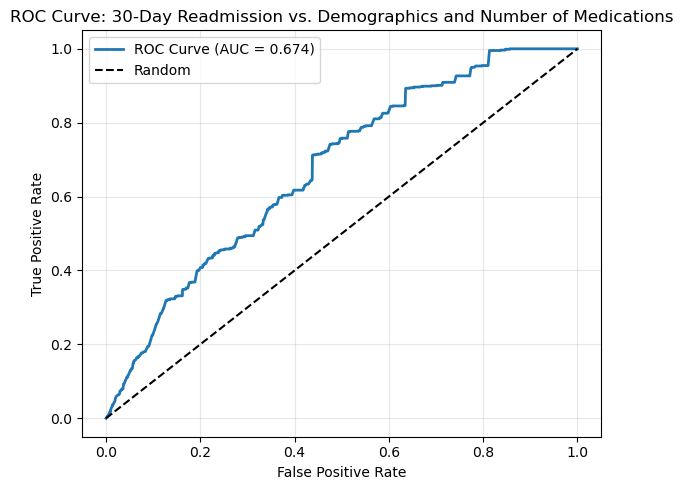

<Figure size 600x500 with 0 Axes>

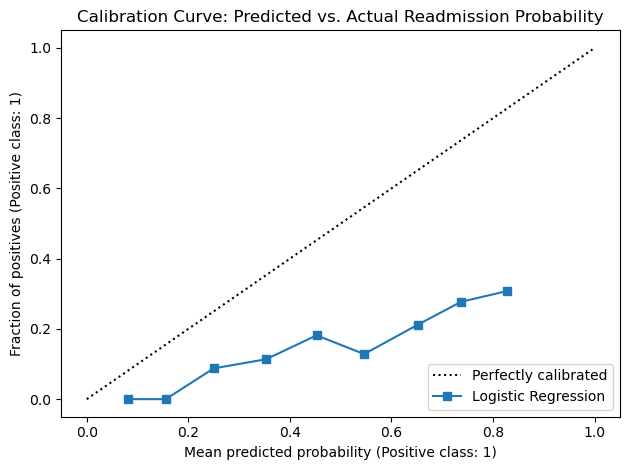

In [42]:
# --- ROC Curve

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})", linewidth=2)
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: 30-Day Readmission vs. Demographics and Number of Medications")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# --- Calibration Curve

plt.figure(figsize=(6, 5))
CalibrationDisplay.from_estimator(
    model,
    X_test,
    y_test,
    n_bins=10,
    strategy='uniform',
    name="Logistic Regression"
)
plt.title("Calibration Curve: Predicted vs. Actual Readmission Probability")
plt.tight_layout()
plt.show()